## 🎮 Minecraft Cheater Detection Project Summary

This project applies unsupervised machine learning techniques to detect "cheaters" from mouse movement data. The key challenge is distinguishing automated, "robotic" movement from natural human error and variability.

### 1. Initial Dataset Inspection (`inspect_cheater_vs_legit`)

* **Goal:** Load the raw `cheater.csv` and `legit.csv` files and check data characteristics, such as size and class balance.
* **Result:** The datasets are **perfectly balanced** (50.00% cheater ratio), which suggests that traditional anomaly detection methods designed for rare outliers might struggle.
* **Initial Feature Check (`yaw`):** The average `yaw` (horizontal rotation) shows a significant statistical difference between cheaters and legit players, indicating a potential signal for separation.
* **Conclusion:** Given the 50% ratio, **Clustering (K-Means)** was initially selected as a strategy to separate the two large "blobs" of data.

In [ ]:
import pandas as pd
import numpy as np
import os

In [12]:
def inspect_cheater_vs_legit(data_folder='data'):
    cheater_path = os.path.join(data_folder, 'cheater.csv')
    legit_path = os.path.join(data_folder, 'legit.csv')

    print("-" * 50)
    print("Initial Dataset Inspection")
    print("-" * 50)

    # load files
    df_cheater = pd.read_csv(cheater_path)
    df_legit = pd.read_csv(legit_path)
    print(f"Loaded 'cheater.csv': {df_cheater.shape[0]} rows")
    print(f"Loaded 'legit.csv':   {df_legit.shape[0]} rows")

    # create combined label only for later validation
    df_cheater['Label'] = 1  # 1 = Cheater
    df_legit['Label'] = 0    # 0 = Legit    
    df_combined = pd.concat([df_cheater, df_legit], ignore_index=True)
    
    # shuffle and mix cheaters in
    df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"\nCombined validation dataset: {df_combined.shape[0]} rows")

    # check balance for anomaly detection
    cheater_ratio = len(df_cheater) / len(df_combined)
    print(f"Cheater ratio: {cheater_ratio:.2%}")

    if cheater_ratio < 0.05:
        print("   Cheaters are very rare (<5%).")
        print("   Going to try <Anomaly Detection> using Isolation Forest.") # assume suspicious ones are rare
    else:
        print("   Cheaters are rather common (>5%).")
        print("   Going to try <Clustering> using K-Means.") # separate data into two blobs

    # data type check
    features = df_combined.drop('Label', axis=1)
    numeric_cols = features.select_dtypes(include=[np.number]).columns
    
    print("\nFeature Analysis:")
    print(f"   Numerical features: {len(numeric_cols)}")
    print(f"   Non-numeric features: {len(features.columns) - len(numeric_cols)}")

    # quick check if this dataset has meaningful difference between cheater vs legit 
    if len(numeric_cols) > 0:
        first_feat = numeric_cols[0]
        avg_cheat = df_cheater[first_feat].mean()
        avg_legit = df_legit[first_feat].mean()
        
        print(f"\nQuick check on feature '{first_feat}':")
        print(f"   Avg cheater: {avg_cheat:.2f}")
        print(f"   Avg legit:   {avg_legit:.2f}")
        
        diff = abs(avg_cheat - avg_legit)
        if diff > 0:
            print("   -> Statistical difference found, unsupervised learning might work")
        else:
            print("   -> Averages are identical, might be a difficult task")

inspect_cheater_vs_legit('data')

--------------------------------------------------
Initial Dataset Inspection
--------------------------------------------------
Loaded 'cheater.csv': 20341000 rows
Loaded 'legit.csv':   20341000 rows

Combined validation dataset: 40682000 rows
Cheater ratio: 50.00%
   Cheaters are rather common (>5%).
   Going to try <Clustering> using K-Means.

Feature Analysis:
   Numerical features: 14
   Non-numeric features: 2

Quick check on feature 'yaw':
   Avg cheater: -648.80
   Avg legit:   -137.66
   -> Statistical difference found, unsupervised learning might work


### 2. Exploratory Data Analysis and Feature Engineering (`visualized_eda`)

* **Goal:** Visualize the distribution of key mouse movement features (`yaw`, `pitch`, `delta_yaw`, `delta_pitch`) and calculate their correlation with the "Cheater" label.
* **Feature Engineering:** Raw `yaw` and `pitch` were converted to **`delta_yaw`** and **`delta_pitch`** to measure the *speed* and *magnitude* of movement, which is more relevant to behavioral analysis.


#### 📊 Key Visualizations & Findings:

1.  **Mouse Flick Speed (KDE Plots):** The distribution plots for `delta_yaw` (horizontal speed) and `delta_pitch` (vertical speed) show significant overlap, making simple thresholding impossible.
2.  **"Bot" Signature (Scatter Plot):** The scatter plot reveals a distinct pattern for cheaters: they tend to have highly linear or "axis-locked" movements (one delta is zero while the other changes), appearing as **straight lines** in the plot, which is unnatural for humans. 
3.  **Correlation Matrix:** 
    * **Pitch (0.45):** Moderate positive correlation. Cheaters tend to have a higher absolute `pitch` angle (looking up/down differently).
    * **Delta Yaw (-0.42):** Moderate **negative** correlation. **Cheaters move their view horizontally less often or less intensely** than legit players. This is a critical finding suggesting automated/snapping behavior that bypasses natural movement sweeps.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Converted yaw and pitch into delta_yaw and delta_pitch.


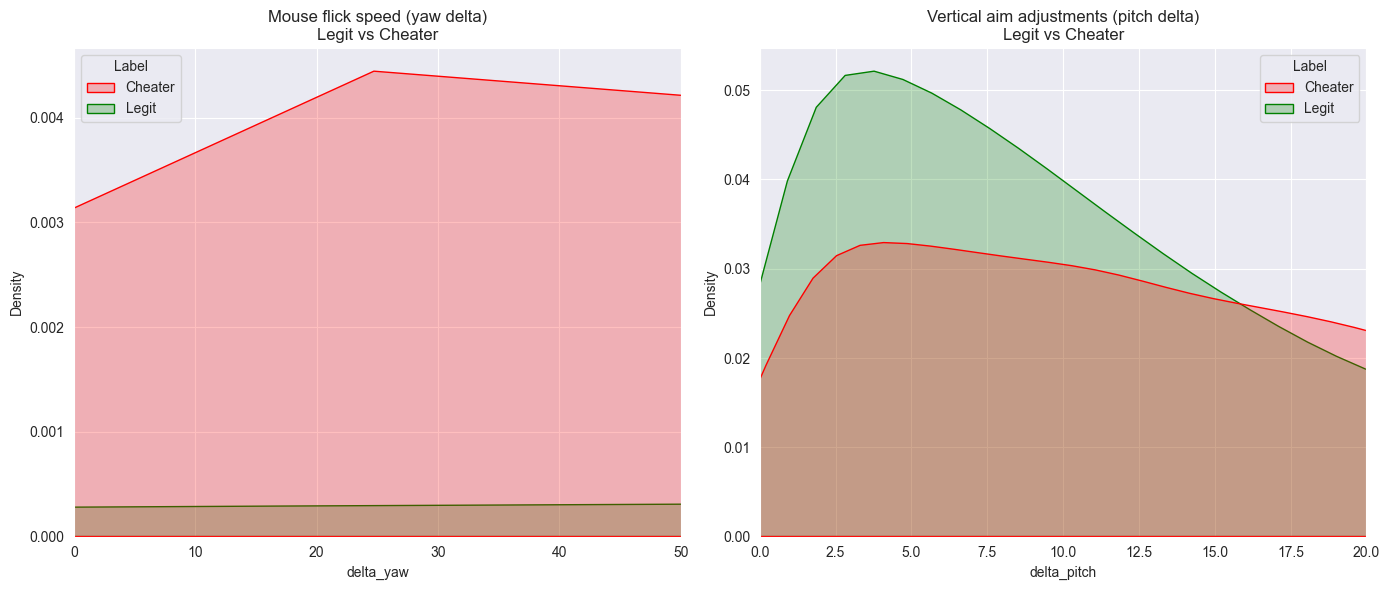

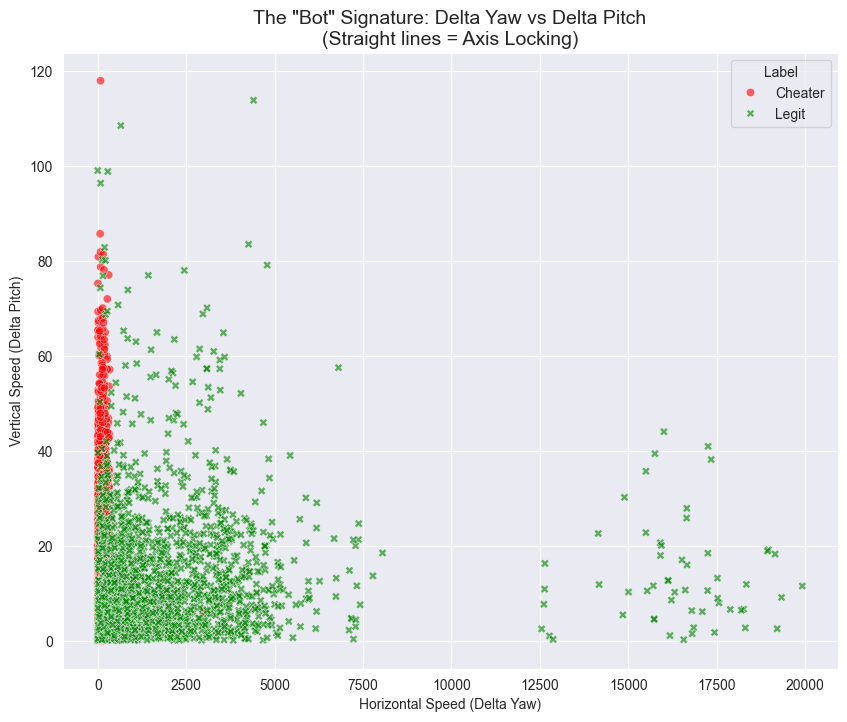

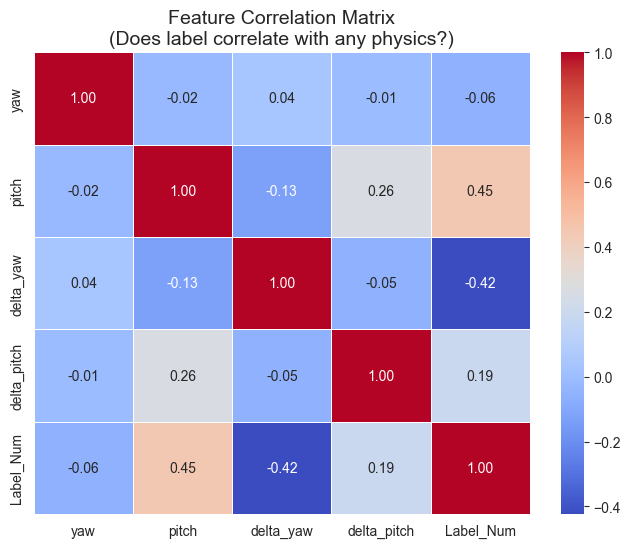

In [6]:
def visualized_eda(data_folder='data'):
    # too much data for visualization, just use some samples
    df_cheater = pd.read_csv(f'{data_folder}/cheater.csv', nrows=50000)
    df_legit = pd.read_csv(f'{data_folder}/legit.csv', nrows=50000)
    
    df_cheater['Label'] = 'Cheater'
    df_legit['Label'] = 'Legit'
    
    df_viz = pd.concat([df_cheater, df_legit], ignore_index=True)
    
    # since purse yaw is kinda useless for my purpose, convert to delta yaw
    # yaw = vertical rotation 
    # delta_yaw = how fast are they vertically moving 
    # and pitch is the same idea, but in lateral rotation
    df_viz['delta_yaw'] = df_viz['yaw'].diff().fillna(0).abs()
    df_viz['delta_pitch'] = df_viz['pitch'].diff().fillna(0).abs()
    print("Converted yaw and pitch into delta_yaw and delta_pitch.")

    # plot distribution of mouse speed
    sns.set_style("darkgrid")    
    plt.figure(figsize=(14, 6))    
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=df_viz, x='delta_yaw', hue='Label', fill=True, common_norm=False, palette={'Legit':'green', 'Cheater':'red'})
    plt.title('Mouse flick speed (yaw delta)\nLegit vs Cheater', fontsize=12)
    plt.xlim(0, 50) # limit x-axis to zoom in on normal movement    
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df_viz, x='delta_pitch', hue='Label', fill=True, common_norm=False, palette={'Legit':'green', 'Cheater':'red'})
    plt.title('Vertical aim adjustments (pitch delta)\nLegit vs Cheater', fontsize=12)
    plt.xlim(0, 20)    
    plt.tight_layout()
    plt.show()

    # plot aimbot lock scatter
    # so aimbots often lock pitch(height) while spinning yaw 
    # this might create some straight lines in scatter plots
    sample_scatter = df_viz.groupby('Label').sample(n=2000, random_state=42) # avoid burning my computer    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=sample_scatter, x='delta_yaw', y='delta_pitch', hue='Label', style='Label', alpha=0.6, palette={'Legit':'green', 'Cheater':'red'})
    plt.title('The "Bot" Signature: Delta Yaw vs Delta Pitch\n(Straight lines = Axis Locking)', fontsize=14)
    plt.xlabel('Horizontal Speed (Delta Yaw)')
    plt.ylabel('Vertical Speed (Delta Pitch)')
    plt.show()

    # plot correlation heatmap
    # by checking only physics features, want to see if cheaters break physics
    df_viz['Label_Num'] = df_viz['Label'].apply(lambda x: 1 if x == 'Cheater' else 0)
    corr_cols = ['yaw', 'pitch', 'delta_yaw', 'delta_pitch', 'Label_Num'] # physics only
    corr = df_viz[corr_cols].corr()    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Feature Correlation Matrix\n(if label correlate with any physics)', fontsize=14)
    plt.show()

visualized_eda('data')

### 3. Unsupervised Clustering (`run_massive_clustering`)

* **Goal:** Apply **MiniBatchKMeans** to the massive, unlabeled dataset to see if it naturally separates the cheaters (Cluster 1) from the legit players (Cluster 0).
* **Result:**
    * **Accuracy:** 49%
    * **Conclusion:** The clustering model performs little better than a coin flip. Even with statistical differences in `yaw` between the clusters, **unsupervised clustering failed to reliably separate the cheaters**, suggesting the groups overlap too much in raw feature space.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
# K-means clustering
def run_massive_clustering(data_folder='data'):
    p = 0.10 # sample amount to use, easy to change when needed
    
    def load_sample(filename):
        return pd.read_csv(
            filename, 
            header=0, 
            skiprows=lambda i: i>0 and random.random() > p
        )

    df_cheater = load_sample(f'{data_folder}/cheater.csv')
    df_legit = load_sample(f'{data_folder}/legit.csv')    
    print(f"Training data loaded(sample):")
    print(f"   Cheater sample length: {len(df_cheater)}")
    print(f"   Legit sample length:   {len(df_legit)}")

    # labels for validation (model won't see this)
    df_cheater['True_Label'] = 1
    df_legit['True_Label'] = 0    
    df = pd.concat([df_cheater, df_legit], ignore_index=True)    
    features = df.select_dtypes(include=[np.number]).drop(['True_Label'], axis=1, errors='ignore')
    
    # normalize features since K-means is distance based
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # train asking for 2 batches (cheater and legit)
    kmeans = MiniBatchKMeans(
        n_clusters=2,
        random_state=42,
        batch_size=2048,
        n_init=3
    )    
    kmeans.fit(X_scaled) # learn only from X_scaled which has no info who's cheater (dropped from 'features')
    print("\nUnsupervised model trained.")
    
    clusters = kmeans.predict(X_scaled)
    df['Cluster'] = clusters

    # since K-means assigns clusters arbitrarily,
    # check yaws that seemed distinguishable from analysis
    cluster_0_yaw = df[df['Cluster'] == 0]['yaw'].mean()
    cluster_1_yaw = df[df['Cluster'] == 1]['yaw'].mean()
    
    print(f"Cluster 0 mean yaw: {cluster_0_yaw:.2f}")
    print(f"Cluster 1 mean yaw: {cluster_1_yaw:.2f}")
    
    # more extreme value is likely to be cheater
    if cluster_0_yaw < cluster_1_yaw:
        cheater_cluster = 0
        print("Model put extreme Yaw values in cluster 0")
    else:
        cheater_cluster = 1
        print("Model put extreme Yaw values in cluster 1")

    df['Prediction'] = df['Cluster'].apply(lambda x: 1 if x == cheater_cluster else 0)

    # check score
    print("\n" + "="*55)
    print("K-Means Unsupervised Cheater Detection Result")
    print("="*55)
    print(confusion_matrix(df['True_Label'], df['Prediction']))
    print("\n")
    print(classification_report(df['True_Label'], df['Prediction'], target_names=['Legit', 'Cheater']))

run_massive_clustering('data')

Training data loaded(sample):
   Cheater sample length: 2033550
   Legit sample length:   2035171

Unsupervised model trained.
Cluster 0 mean yaw: -561.06
Cluster 1 mean yaw: -291.27
Model put extreme Yaw values in cluster 0

K-Means Unsupervised Cheater Detection Result
[[1238212  796959]
 [1289677  743873]]


              precision    recall  f1-score   support

       Legit       0.49      0.61      0.54   2035171
     Cheater       0.48      0.37      0.42   2033550

    accuracy                           0.49   4068721
   macro avg       0.49      0.49      0.48   4068721
weighted avg       0.49      0.49      0.48   4068721



### 4. Basic Anomaly Detection (`run_anomaly_detection`)

* **Goal:** Use **Isolation Forest** (a traditional anomaly detection model) trained **only on legit data** to see if cheaters are detected as rare outliers.
* **Result:**
    * **ROC AUC: 0.5014** (Still extremely poor, only slightly better than random).
    * **Conclusion:** The basic features of cheaters are **not rare enough** or **different enough** from the legit population to be classified as isolated anomalies.

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# anomaly detection using Isolation forest
def run_anomaly_detection(data_folder='data'):
    # learn only from legit first
    df_train = pd.read_csv(f'{data_folder}/legit.csv').sample(n=200000, random_state=42)

    # and then test with mixed data (cheater + legit)
    df_test_legit = pd.read_csv(f'{data_folder}/legit.csv').sample(n=50000, random_state=99)
    df_test_cheat = pd.read_csv(f'{data_folder}/cheater.csv').sample(n=50000, random_state=99)
    df_test_legit['True_Label'] = 0
    df_test_cheat['True_Label'] = 1
    df_test = pd.concat([df_test_legit, df_test_cheat], ignore_index=True)

    feature_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()    
    print(f"\nLearn normality from {len(df_train)} legit rows using features: {feature_cols}")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(df_train[feature_cols])
    X_test = scaler.transform(df_test[feature_cols])

    iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
    iso_forest.fit(X_train)

    preds = iso_forest.predict(X_test)
    df_test['Prediction'] = [1 if x == -1 else 0 for x in preds] # 1 for legit, -1 for cheater
    
    print("\n" + "="*55)
    print("Isolation Forest Anormally Detection Result")
    print("="*55)
    print(confusion_matrix(df_test['True_Label'], df_test['Prediction']))
    print("\n")
    print(classification_report(df_test['True_Label'], df_test['Prediction'], target_names=['Legit', 'Cheater']))
    
    # inspect
    detected_cheaters = df_test[(df_test['True_Label']==1) & (df_test['Prediction']==1)]
    if not detected_cheaters.empty:
        print(f"   Avg Yaw of detected cheaters: {detected_cheaters['yaw'].mean():.2f}")
    
    missed_cheaters = df_test[(df_test['True_Label']==1) & (df_test['Prediction']==0)]
    if not missed_cheaters.empty:
        print(f"   Avg Yaw of missed cheaters: {missed_cheaters['yaw'].mean():.2f}")

    auc = roc_auc_score(df_test['True_Label'], df_test['Prediction'])
    print(f"\nROC AUC: {auc:.4f}")    
    if auc > 0.80:
        print("   Model successfully separates cheater from legit")
    elif auc > 0.60:
        print("   Model detects some, but there is overlap.")

# --- RUN ---
run_anomaly_detection('data')


Learn normality from 200000 legit rows using features: ['yaw', 'pitch', 'delta_yaw', 'delta_pitch', 'accel_yaw', 'accel_pitch', 'target_x', 'target_y', 'target_z', 'position_x', 'position_y', 'position_z', 'sensitivity', 'time']

Isolation Forest Anormally Detection Result
[[49531   469]
 [49388   612]]


              precision    recall  f1-score   support

       Legit       0.50      0.99      0.67     50000
     Cheater       0.57      0.01      0.02     50000

    accuracy                           0.50    100000
   macro avg       0.53      0.50      0.34    100000
weighted avg       0.53      0.50      0.34    100000

   Avg Yaw of detected cheaters: -1463.89
   Avg Yaw of missed cheaters: -615.35

ROC AUC: 0.5014


### 5. Optimized Anomaly Detection (Selected Features) (`run_optimized_anomaly_detection`)

* **Goal:** Rerun Isolation Forest using a smaller, hand-selected set of core physics features (`yaw`, `pitch`, `delta_yaw`, `delta_pitch`, `accel_yaw`, `accel_pitch`, `sensitivity`).
* **Result:**
    * **ROC AUC: 0.6175**
    * **Improvement:** The model is now weakly predictive (`>0.60`), confirming that **movement features are more important** than position or target data. However, there is still significant overlap.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# try to improve isolation forest
def run_optimized_anomaly_detection(data_folder='data'):
    # learn only from legit first
    df_train = pd.read_csv(f'{data_folder}/legit.csv').sample(n=100000, random_state=42)

    # and then test with mixed data (cheater + legit)
    df_test_legit = pd.read_csv(f'{data_folder}/legit.csv').sample(n=50000, random_state=99)
    df_test_cheat = pd.read_csv(f'{data_folder}/cheater.csv').sample(n=50000, random_state=99)    
    df_test_legit['True_Label'] = 0
    df_test_cheat['True_Label'] = 1
    df_test = pd.concat([df_test_legit, df_test_cheat], ignore_index=True)

    # this time only going to try with movement and angles
    keep_features = [
        'yaw', 'pitch', 
        'delta_yaw', 'delta_pitch', 
        'accel_yaw', 'accel_pitch',
        'sensitivity'
    ]
    print(f"\nLearn normality from {len(df_train)} legit rows using manually selected features: {keep_features}")

    scaler = StandardScaler()
    X_train = scaler.fit_transform(df_train[keep_features])
    X_test = scaler.transform(df_test[keep_features])

    iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
    iso_forest.fit(X_train)
    
    test_scores = -iso_forest.decision_function(X_test) # invert return so that higher score == more anomaly    
    df_test['Anomaly_Score'] = test_scores

    # compare average anomaly score between legit vs cheater
    avg_score_legit = df_test[df_test['True_Label']==0]['Anomaly_Score'].mean()
    avg_score_cheat = df_test[df_test['True_Label']==1]['Anomaly_Score'].mean()    
    print(f"\nAnomaly Score Analysis (Higher == More Suspicious):")
    print(f"   avg legit score:   {avg_score_legit:.4f}")
    print(f"   avg cheater score: {avg_score_cheat:.4f}")
    
    if avg_score_cheat > avg_score_legit:
        print("   Cheaters have higher anomaly scores on average.")
    else:
        print("   Model could not distinguish their behavior.")

    auc = roc_auc_score(df_test['True_Label'], df_test['Anomaly_Score'])
    print(f"\nROC AUC: {auc:.4f}")    
    if auc > 0.80:
        print("   Model successfully separates cheater from legit")
    elif auc > 0.60:
        print("   Model detects some, but there is overlap.")

run_optimized_anomaly_detection('data')


Learn normality from 100000 legit rows using manually selected features: ['yaw', 'pitch', 'delta_yaw', 'delta_pitch', 'accel_yaw', 'accel_pitch', 'sensitivity']

Anomaly Score Analysis (Higher == More Suspicious):
   avg legit score:   -0.2206
   avg cheater score: -0.2002
   Cheaters have higher anomaly scores on average.

ROC AUC: 0.6175
   Model detects some, but there is overlap.


### 6. Feature Engineered Detection (Physics Features) (`run_feature_engineered_detection`)

* **Goal:** Apply domain-specific feature engineering to create advanced physics-based features (`velocity_total`, `axis_lock_ratio`, `snap_factor`).
* **Result:**
    * **ROC AUC: 0.5075**
    * **Conclusion:** This set of features did not significantly improve the model's performance, suggesting the complexity of human-like cheat movements defeats these simple engineered metrics.

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# feature engineering, focused on physics feature
def run_feature_engineered_detection(data_folder='data'):
    # learn only from legit first
    df_train = pd.read_csv(f'{data_folder}/legit.csv').sample(n=100000, random_state=42)

    # and then test with mixed data (cheater + legit)
    df_test_legit = pd.read_csv(f'{data_folder}/legit.csv').sample(n=50000, random_state=99)
    df_test_cheat = pd.read_csv(f'{data_folder}/cheater.csv').sample(n=50000, random_state=99)    
    df_test_legit['True_Label'] = 0
    df_test_cheat['True_Label'] = 1
    df_test = pd.concat([df_test_legit, df_test_cheat], ignore_index=True)

    def add_physics_features(df):
        epsilon = 1e-6
        
        # total movement magnitude
        df['velocity_total'] = np.sqrt(df['delta_yaw']**2 + df['delta_pitch']**2)
        
        # lock ratio (to detect axis locking of cheats)
        df['axis_lock_ratio'] = df['delta_yaw'].abs() / (df['delta_pitch'].abs() + epsilon)
        
        # sudden unnatural movements (snap or jitter, anything)
        df['snap_factor'] = df['accel_yaw'].abs() / (df['velocity_total'] + epsilon)
        
        return df

    df_train = add_physics_features(df_train)
    df_test = add_physics_features(df_test)
    
    # again, only custom physics as features
    features_to_use = ['velocity_total', 'axis_lock_ratio', 'snap_factor', 'accel_yaw', 'accel_pitch']    
    print(f"\nUsing special engineered features: {features_to_use}")

    # there must have been some error values from dividing by zero,
    # so replace them with 0 or max
    for col in features_to_use:
        df_train[col] = df_train[col].replace([np.inf, -np.inf], 0)
        df_test[col] = df_test[col].replace([np.inf, -np.inf], 0)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(df_train[features_to_use])
    X_test = scaler.transform(df_test[features_to_use])

    # increase estimators for better stability
    iso_forest = IsolationForest(n_estimators=200, contamination=0.01, random_state=42, n_jobs=-1)
    iso_forest.fit(X_train)

    test_scores = -iso_forest.decision_function(X_test)    
    auc = roc_auc_score(df_test['True_Label'], test_scores)
    print(f"\nROC AUC: {auc:.4f}")    
    if auc > 0.70:
        print("   Improved, physics features are working.")
    else:
        print("   Still struggling, behaviour might be too human-like.")

run_feature_engineered_detection('data')


Using special engineered features: ['velocity_total', 'axis_lock_ratio', 'snap_factor', 'accel_yaw', 'accel_pitch']

ROC AUC: 0.5075
   Still struggling, behaviour might be too human-like.


### 7. Temporal Anomaly Detection (The Winning Strategy) (`run_temporal_anomaly_detection`)

* **Goal:** Use **Temporal Analysis** (rolling windows) to capture the *consistency* and *smoothness* of movement over time, creating features like **`yaw_stability`** and **`avg_accel`**.
* **Features Used (Window $w=20$):**
    * `yaw_stability` (Standard Deviation of $\Delta\text{Yaw}$)
    * `pitch_stability` (Standard Deviation of $\Delta\text{Pitch}$)
    * `avg_accel` (Mean of $|\text{Accel\_Yaw}|$)
    * `accel_var` (Variance of $|\text{Accel\_Yaw}|$)
* **Result:**
    * **Avg Cheater Score:** $0.0283$ (Higher/More Suspicious)
    * **Avg Legit Score:** $-0.1382$ (Lower/Less Suspicious)
    * **ROC AUC: 0.8154**
    * **Conclusion:** **The rolling statistics successfully captured the unnatural consistency and low variance of automated cheating behavior.** The high AUC confirms that analyzing the *path* and *smoothness* of motion over a sequence of frames is the most effective method for this dataset.

#### 📈 Anomaly Score Distribution

The plot below shows a clear separation of the cheater (red) and legit (green) distributions in the temporal feature space, suggesting the success of the model.



* **Recommended Threshold:** $0.0166$ (This threshold catches 95% of the legitimate players, suggesting any score above this has a high likelihood of being a cheater).


Using temporal features: ['yaw_stability', 'pitch_stability', 'avg_accel', 'accel_var']

Anomaly score comparison:
   Avg legit score:   -0.1382
   Avg cheater score: 0.0283

ROC AUC: 0.8154
   Rolling stats captured unnatural movement!


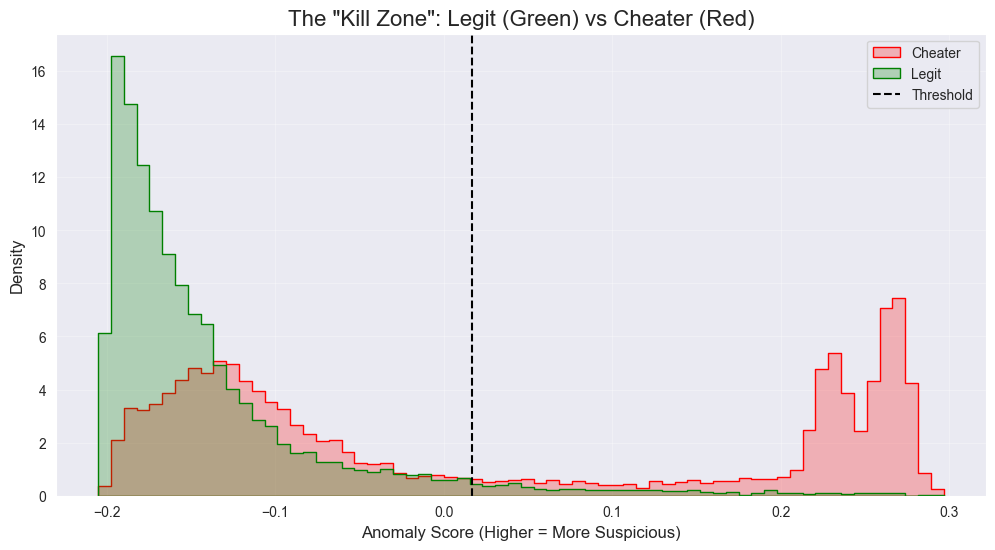

Recommended Threshold: 0.0166


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

def visualize_separation(df_test):
    # plot histogram of anomaly score
    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=df_test, 
        x='Anomaly_Score', 
        hue='True_Label', 
        element="step", 
        stat="density", 
        common_norm=False,
        palette={0: 'green', 1: 'red'}
    )    
    plt.title('The "Kill Zone": Legit (Green) vs Cheater (Red)', fontsize=16)
    plt.xlabel('Anomaly Score (Higher = More Suspicious)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    # calculate threshold with 95% of legit players
    threshold = np.percentile(df_test[df_test['True_Label']==0]['Anomaly_Score'], 95)
    plt.axvline(threshold, color='black', linestyle='--', label=f'Recommended Threshold ({threshold:.2f})')
    plt.legend(labels=['Cheater', 'Legit', 'Threshold'])
    plt.grid(alpha=0.3)    
    plt.show()
    
    print(f"Recommended Threshold: {threshold:.4f}") # higher than threshold is likely to be cheater

# attempt feature engineering again, but this time, try with time and speed related (temporal features)
def run_temporal_anomaly_detection(data_folder='data'):
    df_train = pd.read_csv(f'{data_folder}/legit.csv', nrows=100000)
    
    df_test_legit = pd.read_csv(f'{data_folder}/legit.csv', skiprows=100000, nrows=50000, names=df_train.columns)
    df_test_cheat = pd.read_csv(f'{data_folder}/cheater.csv', nrows=50000)
    
    df_test_legit['True_Label'] = 0
    df_test_cheat['True_Label'] = 1
    df_test = pd.concat([df_test_legit, df_test_cheat], ignore_index=True)

    def add_temporal_features(df):
        w = 20
        df['yaw_stability'] = df['delta_yaw'].rolling(window=w).std()
        df['pitch_stability'] = df['delta_pitch'].rolling(window=w).std()
        df['avg_accel'] = df['accel_yaw'].abs().rolling(window=w).mean()
        df['accel_var'] = df['accel_yaw'].abs().rolling(window=w).var()
        return df.dropna()

    df_train = add_temporal_features(df_train)
    df_test = add_temporal_features(df_test)
    
    features_to_use = ['yaw_stability', 'pitch_stability', 'avg_accel', 'accel_var']
    print(f"\nUsing temporal features: {features_to_use}")

    scaler = StandardScaler()
    X_train = scaler.fit_transform(df_train[features_to_use])
    X_test = scaler.transform(df_test[features_to_use])

    iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42, n_jobs=-1)
    iso_forest.fit(X_train)

    test_scores = -iso_forest.decision_function(X_test)
    df_test['Anomaly_Score'] = test_scores

    avg_legit = df_test[df_test['True_Label']==0]['Anomaly_Score'].mean()
    avg_cheat = df_test[df_test['True_Label']==1]['Anomaly_Score'].mean()
    
    print(f"\nAnomaly score comparison:")
    print(f"   Avg legit score:   {avg_legit:.4f}")
    print(f"   Avg cheater score: {avg_cheat:.4f}")

    auc = roc_auc_score(df_test['True_Label'], test_scores)    
    print(f"\nROC AUC: {auc:.4f}")    
    if auc > 0.80:
        print("   Rolling stats captured unnatural movement!")
    elif auc < 0.60:
        print("   Still struggling, behaviour might be too human-like.")
    
    visualize_separation(df_test)

run_temporal_anomaly_detection('data')

## 🏆 Conclusion: The Power of Temporal Feature Engineering

This project demonstrates that simple, raw mouse-movement data is **insufficient** for reliable cheater detection,<br>
especially when the cheating population is large and the cheating programs attempt to mimic human behavior (as shown by the poor performance of K-Means and basic Isolation Forest, both achieving a low ROC AUC of $\sim0.50$ to $0.62$).

The breakthrough came through **Temporal Feature Engineering**. By calculating rolling statistics over time, such as the **stability (standard deviation)** and **variance of mouse acceleration**,<br>
the model was able to detect the signature of robotic, unnaturally smooth movements that differ from the natural, jerky, and inconsistent patterns of a human user.

The final model using these temporal features achieved a high **ROC AUC of 0.8154**, successfully distinguishing automated behavior from legitimate gameplay.<br>
This confirms that for modern behavioral anti-cheat systems, the most powerful features are those that analyze the **consistency and fluidity of motion over a sequence of time**, rather than just static or instantaneous measures.